In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np

from abc_merfish_analysis import ccf_plots as cplots
from abc_merfish_analysis import ccf_images as cimg
from abc_merfish_analysis import abc_load as abc
import abc_merfish_analysis.distance_metrics as dm
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

# Load ABC data + SpaGCN domains predictions

In [4]:
# load all cells in the brain 
# (realigned=True would load faster version)
realigned=False
obs = abc.get_combined_metadata(realigned=realigned)

In [5]:
# load in SpaGCN domain results
# temporarily a static file in '../code/resources' until I get a reproducible run setup for the spagcn capsule
spagcn_domains_df = pd.read_parquet('/data/spagcn/spagcn_predicted_domains.parquet')

# need to convert to categories since they're imported as int64
spagcn_domains_df = spagcn_domains_df.astype('category')
spagcn_domains_df

,res1pt4,res1pt0,res0pt7
cell_label,,,
1018093344101120291-2,22,18,10
1018093344101120325-1,22,18,10
1018093344101110066-3,14,18,17
1018093344100960681-1,14,18,9
1018093344101110238-1,14,18,9
...,...,...,...
1018093345101610118-1,17,14,15
1018093345101620074,17,14,15
1018093345101450752-1,17,14,15


In [6]:
# merge in & subset to just cells with SpaGCN domain predictions
obs_spagcn = pd.merge(obs, spagcn_domains_df, on='cell_label', how='inner')

## Set up other parameters

In [7]:
section_col = 'z_reconstructed'
sections_all = sorted(obs_spagcn[section_col].unique())
print(f'{sections_all}')

# 3 example sections for the GRC poster
sections_GRC = [6.4, 7.2, 8.0]

[5.0, 5.4000000000000004, 5.5999999999999996, 5.7999999999999998, 6.2000000000000002, 6.4000000000000004, 6.5999999999999996, 6.7999999999999998, 7.0, 7.2000000000000002, 7.5999999999999996, 7.7999999999999998, 8.0, 8.1999999999999993]


In [8]:
if realigned:
    ccf_label = 'parcellation_structure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_structure'
    coords = 'reconstructed'

## Load CCF structures

In [9]:
ccf_images = abc.get_ccf_labels_image(resampled=True, realigned=realigned, 
                                        subset_to_left_hemi=True)
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True)

# Plots

## plot all sections to double check data import

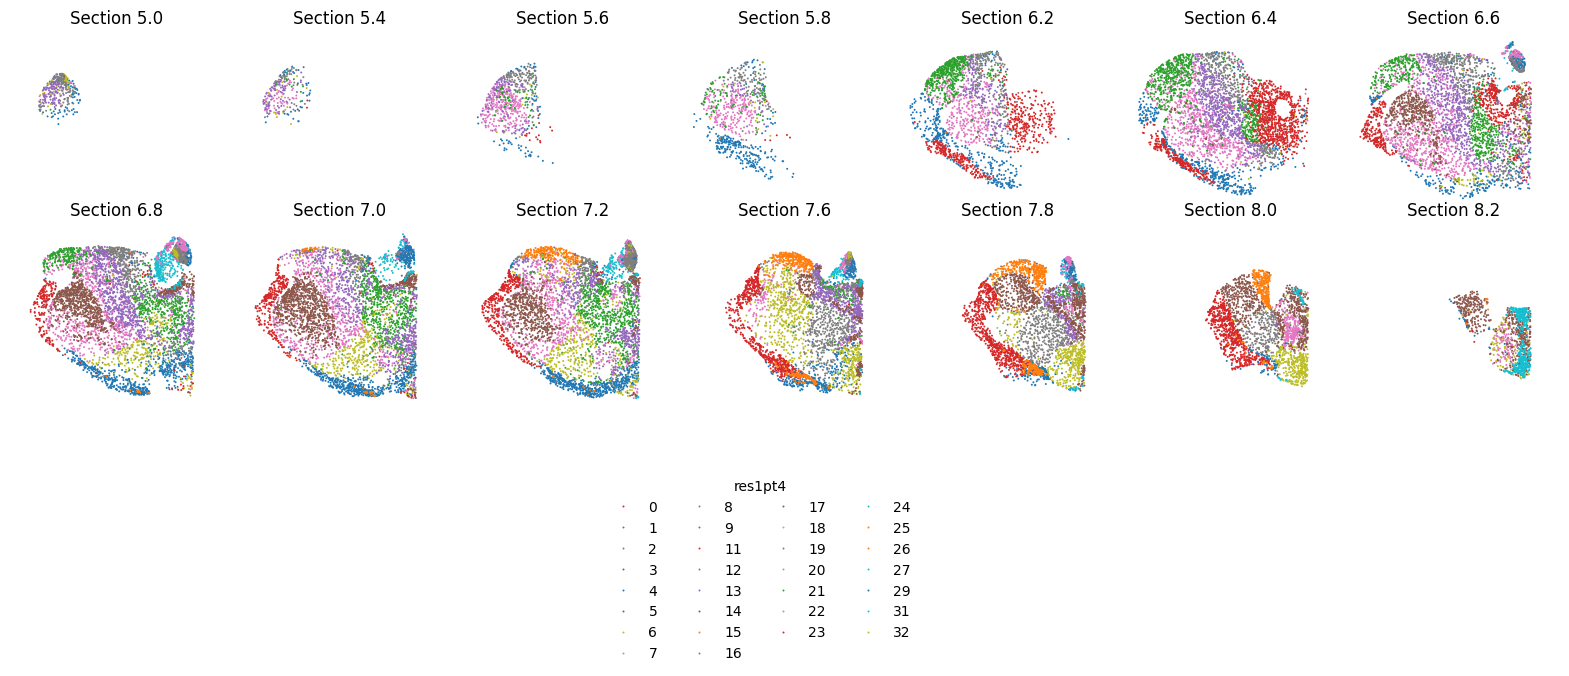

In [10]:
resolution = 1.4
res_str = str(resolution)
predicted_col = f'res{res_str[0]}pt{res_str[-1]}'
predicted_refined_col = f'res{res_str[0]}pt{res_str[-1]}_refined'

fig_all_sec = cplots.plot_ccf_overlay(
    obs_spagcn,
    ccf_images=None,
    point_hue=predicted_col,
    separate_figs=False,
    n_rows=2,
    figsize=(20, 5),
    legend="cells",
    section_col=section_col,
    x_col="x_" + coords,
    y_col="y_" + coords,
    point_size=2,
    custom_xy_lims=[2.5, 6, 7, 4],
    min_group_count=0,
)
# fig_all_sec.savefig(f'/results/spaGCN_multisec_res{resolution}.pdf', 
#                     transparent=True, bbox_inches='tight')

## Plot SpaGCN domains + CCF overlay

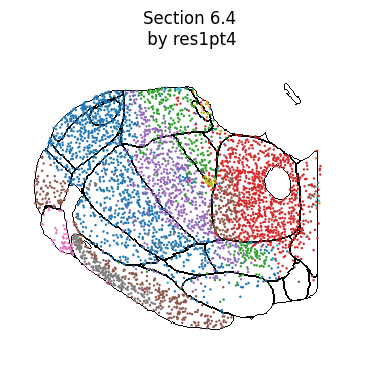

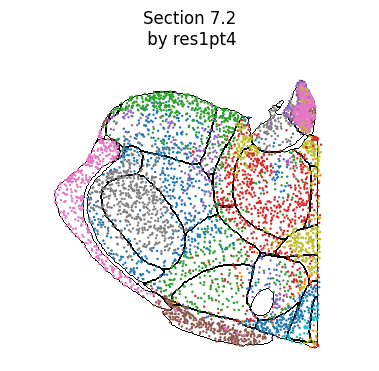

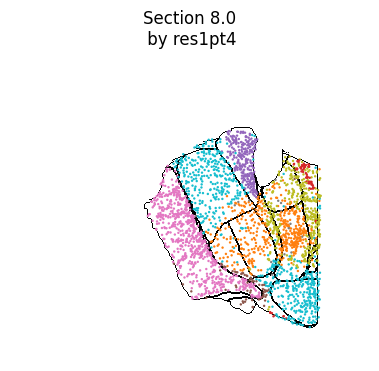

In [11]:
kwargs = dict(
    bg_cells=None,
    section_col=section_col,
    x_col="x_" + coords,
    y_col="y_" + coords,
    point_size=3,
    edge_color="black",
    boundary_img=ccf_boundaries,
    custom_xy_lims=[2.5, 6, 7, 4],
)
figs = cplots.plot_ccf_overlay(
    obs_spagcn,
    ccf_images,
    point_hue=predicted_col,
    sections=sections_GRC,
    # point_palette=abc_palettes['subclass'],
    legend=None,  #'cells',
    **kwargs,
)

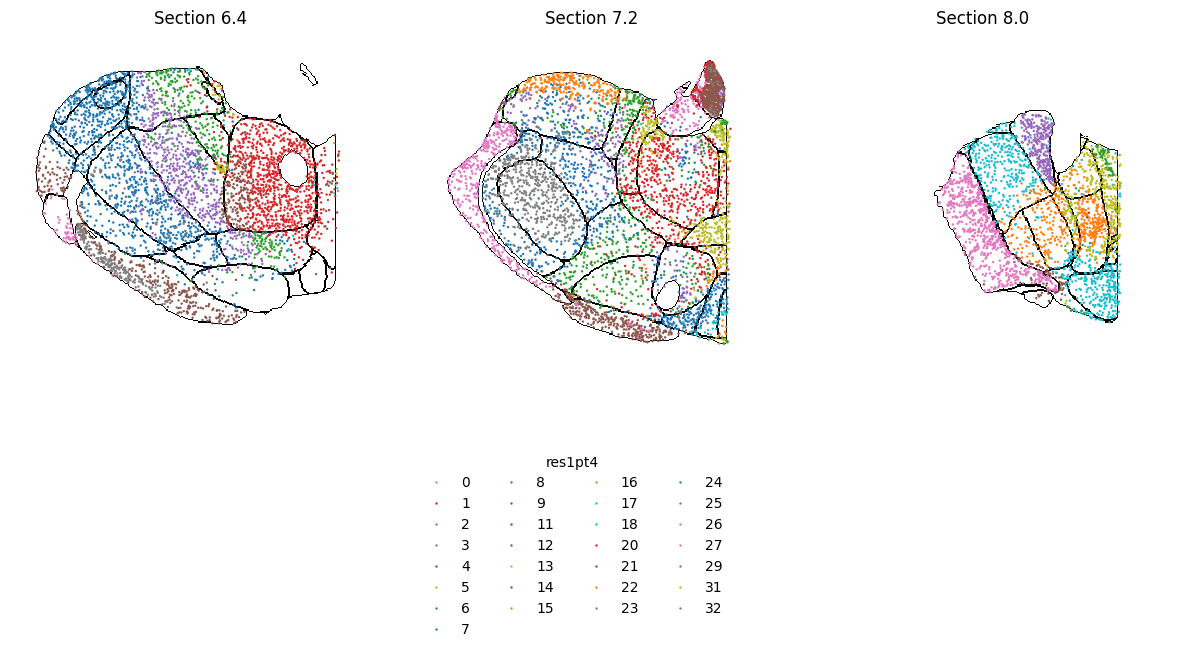

In [12]:

figs = cplots.plot_ccf_overlay(
    obs_spagcn,
    ccf_images,
    point_hue=predicted_col,
    min_group_count=0,
    sections=sections_GRC,
    separate_figs=False,
    figsize=(15, 5),
    legend="cells",
    **kwargs,
)
# fig.savefig(f'../results/spaGCN_domains_ccf_overlay_3sections_res{res_str}.pdf', 
#             transparent=True, bbox_inches='tight')

# Distance Metrics

## CCF overlap

In [13]:
regions_subset = np.array([
    'AD',
    'AV',
    'LD',
    'LGd',
    # VP combine?
    'VPM',
    'VPL',
    'AM',
    'VPMpc',
    'MD',
    'LP',
    'PO',
    'IAD',
    'VAL',
    'VM',
    'RE',
    'CL',
    'PF',
    'CM',
    'PCN',
    'SPA',
    'IMD',
    'PVT',
    # additional
    'MH',
    'LH',
    'RT',
    # 'ZI'
])

In [14]:
regions_final = [
    "AD", "AV", "AM", "IAD", "LD", "VPM", "VPL", "LGd",
    "MD", "CL", "CM", "IMD", "PO", "LP", "VAL", "VM", 
    "RE", "PF", "VPMpc", "PCN", "SPA", "PVT", "MH", "LH", "RT", 
]

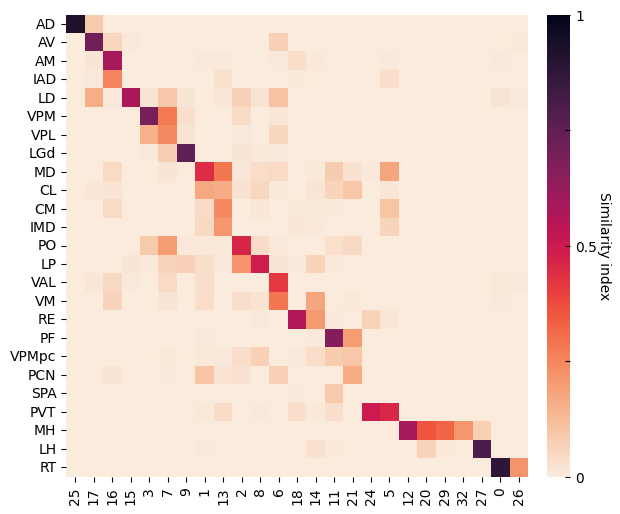

In [15]:
# ccf region order here is fairly arbitrary 
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=ccf_label, x_col=predicted_col, 
                            y_names=regions_final, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)

fig.set_size_inches(7.5,6)

fig.savefig(f'../results/similarity_heatmap_nuclei_vs_spaGCN_domains_reorderedY.pdf', 
            transparent=True, bbox_inches='tight')

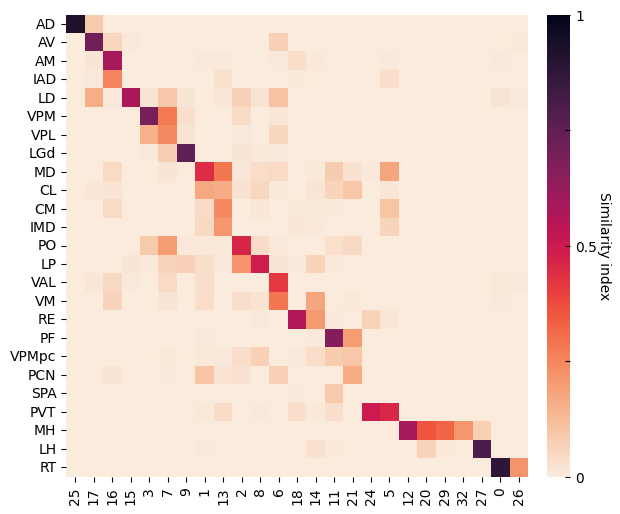

In [16]:
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=ccf_label, x_col=predicted_col, 
                            y_names=regions_final, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)

# fig.gca().axis('equal')
fig.set_size_inches(7.5,6)

fig.savefig(f'../results/similarity_heatmap_nuclei_vs_spaGCN_domains_notReorderedY.pdf', 
            transparent=True, bbox_inches='tight')

## Taxonomy overlap

### subclass

In [17]:
# sorted(obs_spagcn['subclass'].cat.categories.to_list())

In [18]:
subclasses_subset = ['093 RT-ZI Gnb3 Gaba',
                     '101 ZI Pax6 Gaba',
                     '103 PVHd-DMH Lhx6 Gaba',
                     '109 LGv-ZI Otx2 Gaba',
                     '145 MH Tac2 Glut',
                     '146 LH Pou4f1 Sox1 Glut',
                     '147 AD Serpinb7 Glut',
                     '148 AV Col27a1 Glut',
                     '149 PVT-PT Ntrk1 Glut',
                     '150 CM-IAD-CL-PCN Sema5b Glut',
                     '151 TH Prkcd Grin2c Glut',
                     '152 RE-Xi Nox4 Glut',
                     '154 PF Fzd5 Glut',
                     # '168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut', # cut off by midline xcoord bug
                     # '197 SNr Six3 Gaba',
                     # '202 PRT Tcf7l2 Gaba',
                     # '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba' # also cut off by midline xcoord bug??
                     ]

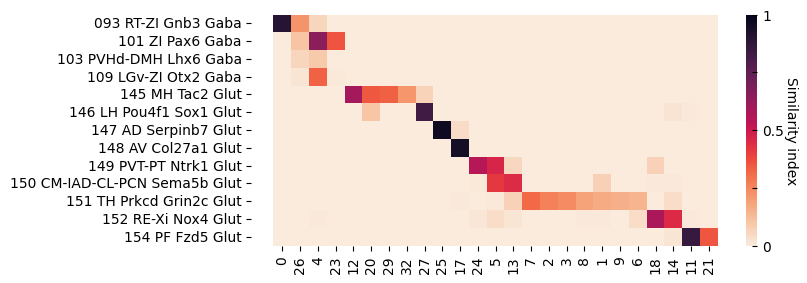

In [19]:
taxonomy_level = 'subclass'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=taxonomy_level, x_col=predicted_col, 
                            y_names=subclasses_subset, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False, 
                                             min_similarity_x=0.1)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)
fig.gca().axis('equal')
fig.set_size_inches(7.5,3)

fig.savefig(f'../results/similarity_heatmap_subclass_vs_spaGCN_domains_reorderedY.pdf', 
            transparent=True, bbox_inches='tight')

### supertype

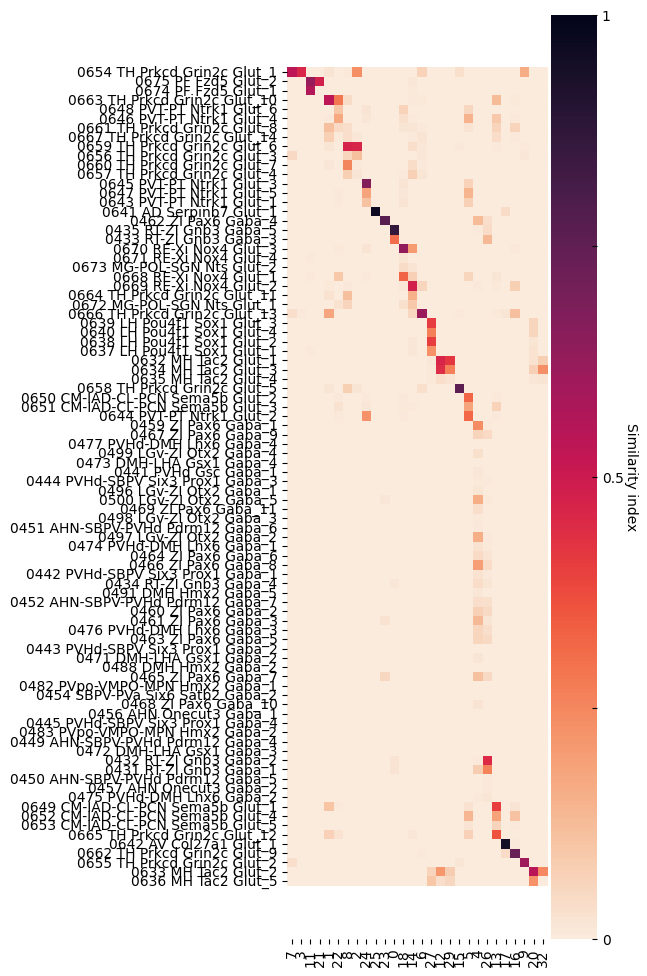

In [20]:
taxonomy_level = 'supertype'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=taxonomy_level, x_col=predicted_col, 
                            y_names=None, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)
fig.gca().axis('equal')
fig.set_size_inches(4, 12)

### clusters

In [21]:
cluster_list = sorted(obs_spagcn['cluster'].cat.categories.to_list())
clusters_grin2c = [cl for cl in cluster_list if 'Grin2c' in cl]
# clusters_grin2c

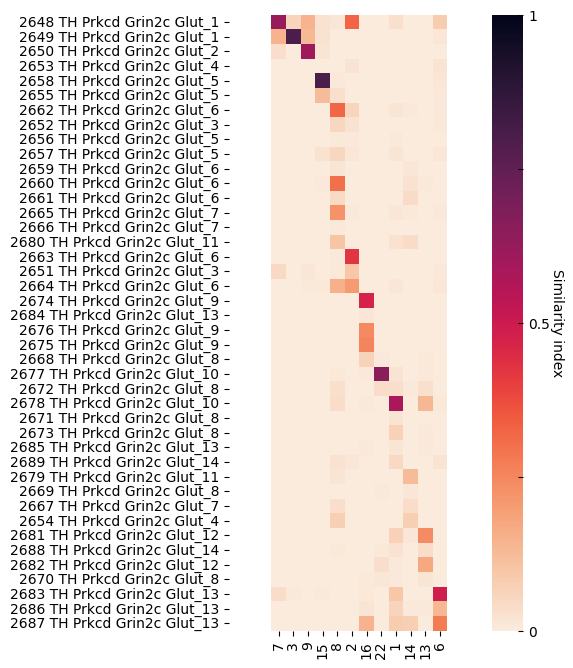

In [22]:
taxonomy_level = 'cluster'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, y_col=taxonomy_level, x_col=predicted_col, 
                            y_names=clusters_grin2c, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

fig = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names)
fig.gca().axis('equal')
fig.set_size_inches(4, 8)